In [1]:
import os
import numpy as np
import pydicom
from scipy import ndimage
import tqdm

high_res_path = '/run/media/trevor/Seagate Backup Plus Drive/trevor_overflow/femur_test_img/F01/'
patches_path = 'patches/'

high_res_voxel_size = 0.033
desired_voxel_size = 0.2
patch_size = 64
overlap_size = 32
# patch_size = 8
# overlap_size = 0


In [2]:
def get_sorted_dicom_files(path):
    dicom_files = [os.path.join(path, f) for f in os.listdir(path)]
    return sorted(dicom_files)


def load_dicom_block(dicom_files, start, end):
    dicom_slices = [pydicom.dcmread(f).pixel_array for f in dicom_files[start:end]]
    img = np.stack(dicom_slices, axis=-1)
    return img

def extract_patches(img, patch_id):
    downsampled_img = ndimage.zoom(img, high_res_voxel_size / desired_voxel_size)
    x_size, y_size, z_size = downsampled_img.shape
    if z_size < patch_size:
        print(f'z size is less than patch size: {z_size}')
        return patch_id
    else:
        downsampled_img = downsampled_img[:, :, :patch_size]

    for x in range(0, x_size, patch_size - overlap_size):
        for y in range(0, y_size, patch_size - overlap_size):
            if x + patch_size <= x_size and y + patch_size <= y_size:
                patch = downsampled_img[x:x+patch_size, y:y+patch_size, :]

                avg_intensity = np.mean(patch)
                if avg_intensity > 600:
                    patch_filename = os.path.join(patches_path, f'{str(patch_id).zfill(8)}.npy')
                    np.save(patch_filename, patch)
                    patch_id += 1
    
    return patch_id

    

In [3]:
high_res_files = get_sorted_dicom_files(high_res_path)
high_res_patch_size = int (patch_size * desired_voxel_size / high_res_voxel_size + 1)
high_res_overlap_size = int (overlap_size * desired_voxel_size / high_res_voxel_size + 1)
patch_id = 0

for i in tqdm.tqdm(range(0, len(high_res_files), high_res_patch_size - high_res_overlap_size)):
    print(i)
    if i + high_res_patch_size <= len(high_res_files):
        img = load_dicom_block(high_res_files, i, i + high_res_patch_size)
        patch_id = extract_patches(img, patch_id)
        print(f'Processed {i} of {len(high_res_files)}')
    break


  0%|          | 0/19 [00:00<?, ?it/s]

0


  0%|          | 0/19 [01:33<?, ?it/s]

Processed 0 of 3500


In [4]:
test = np.load('patches/00000007.npy')

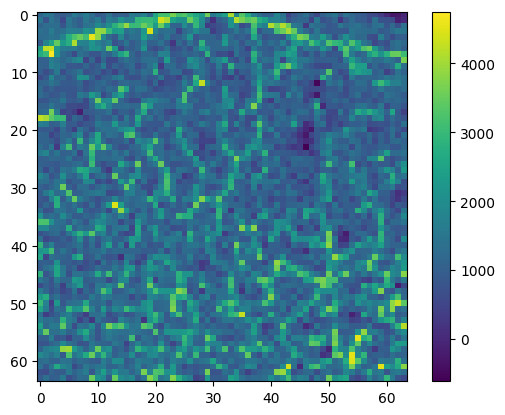

In [5]:
import matplotlib.pyplot as plt

plt.imshow(test[:,:,32])
plt.colorbar()

In [88]:
test_img = pydicom.dcmread('/run/media/trevor/Seagate Backup Plus Drive/trevor_overflow/femur_test_img/F01/C0008408_1_00063.DCM').pixel_array

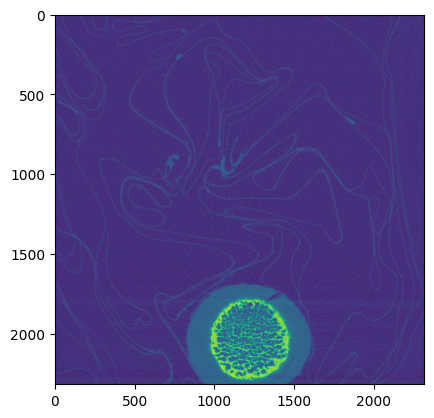

In [86]:
plt.imshow(test_img)